**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [51]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

---

# Unsupervised Machine Learning Approach
## Methodology:  DBSCAN
###  Univariate Temperature Data
---

```Import standard python libraries```

In [52]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import pickle
import datetime
import multiprocessing as mp
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
# default start, but later you can change if you desire 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

```Move directories to read in file```

In [53]:
%cd D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION\

D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION


```Read in data```

In [54]:
pf = pd.read_pickle("SSS.pkl")
# this pickle file was previously created from millions of rows
# of data and then filtered for removal of any NaN values, 
# extensively cleaned and reproduced 

In [55]:
#  --- Data Time Domain ---
#    Date Range:   March 2018 - March 2021
#    Granularity:  25s 
#    Nodes:        Single Node Location

```Plot snipper for understanding```

In [56]:
pf.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2018-03-06 22:14:56,apds_9006_020,intensity,3.537000
2018-03-06 22:14:56,apds_9006_020,intensity,3.537000
2018-03-06 22:14:56,hih6130,humidity,61.830002
2018-03-06 22:14:56,hih6130,humidity,61.830002
2018-03-06 22:14:56,hih6130,temperature,9.620000
2018-03-06 22:14:56,hih6130,temperature,9.620000
2018-03-06 22:14:56,hmc5883l,magnetic_field_x,-148.182007
2018-03-06 22:14:56,hmc5883l,magnetic_field_x,-150.000000
2018-03-06 22:14:56,hmc5883l,magnetic_field_y,-1603.635986


Show number of unique sensors and sensor parameters being recorded:

In [57]:
print('\nThe individual sensors present at this location/node:\n')
c=1
for s in pf.sensor.unique():
    print(c,") ", s)
    c = c+1


The individual sensors present at this location/node:

1 )  apds_9006_020
2 )  hih6130
3 )  hmc5883l
4 )  ml8511
5 )  mlx75305
6 )  tmp421
7 )  tsl250rd
8 )  tsl260rd
9 )  bmp180
10 )  hih4030
11 )  htu21d
12 )  mma8452q
13 )  pr103j2
14 )  spv1840lr5h_b
15 )  tmp112
16 )  tsys01
17 )  at0
18 )  at1
19 )  at2
20 )  at3
21 )  lps25h
22 )  sht25
23 )  co
24 )  h2s
25 )  no2
26 )  o3
27 )  oxidizing_gases
28 )  reducing_gases
29 )  so2


In [58]:
print('\nThe sensor parameters being monitored:\n')
for p in pf.parameter.unique():print(p) # params 


The sensor parameters being monitored:

intensity
humidity
temperature
magnetic_field_x
magnetic_field_y
magnetic_field_z
pressure
acceleration_x
acceleration_y
acceleration_z
concentration


In [59]:
# rebuild at categorical for speed
pf['sensor'] = pf.sensor.astype('category')
pf['parameter'] = pf.parameter.astype('category')

In [60]:
# pf.dtypes
#  sensor       category
#  parameter    category
#  value_hrf     float32
#  dtype: object

In [61]:
print('\nNumber of rows of raw data:\n', len(pf))
#  82M rows... 82 406 931


Number of rows of raw data:
 82406931


In [62]:
print('\nNumber of rows of data ........', f'{len(pf):,}')


Number of rows of data ........ 82,406,931


In [63]:
# date range
print('\nStart .....', pf.head(1).index[0])
print('\nEnd .......', pf.tail(1).index[0])


Start ..... 2018-03-06 22:14:56

End ....... 2021-03-22 05:18:42


In [64]:
print("\nRange of the dates for this particular dataset:")
pf.tail(1).index[0] - pf.head(1).index[0]
# over a thousand days (3 years) of 25s granularity data, not bad


Range of the dates for this particular dataset:


Timedelta('1111 days 07:03:46')

In [65]:
# stop:  you can re-use this code up to here to 
# to spin off multiple sensor analysis if desired
# this is an excellent base dataframe to do more additional examination... 
# but for now we will grab particular window 

---

```Grab window in 2019```

We will grab a particular window in 2019 of just over two months. 

We still have a fair amount of data (given sensors record every 25s, and we have many many sensors at this particular location)

In [66]:
start_date =   '2019-01-01'
end_date =     '2019-02-28'
minidf = pf.loc[start_date:end_date].copy() 

# our base window will be a wide 2 month window to get 
# the core dbscan algorithm working properly
# fyi, len(minidf) # 4,883,544 roughly 5M rows of data 

In [67]:
minidf.head(49) 
# so at this point, i have a single node, and 
# will grab a single sensor and build 

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,apds_9006_020,intensity,0.723000
2019-01-01 00:00:03,hih6130,humidity,24.290001
2019-01-01 00:00:03,hih6130,temperature,28.660000
2019-01-01 00:00:03,hmc5883l,magnetic_field_x,-155.455002
2019-01-01 00:00:03,hmc5883l,magnetic_field_y,-1548.182007
2019-01-01 00:00:03,hmc5883l,magnetic_field_z,-521.429016
2019-01-01 00:00:03,ml8511,intensity,46.351002
2019-01-01 00:00:03,mlx75305,intensity,4.242000
2019-01-01 00:00:03,tmp421,temperature,9.000000


```Filter by parameter of temperature```

In [68]:
# important
#   grabbing the right accurate sensor for this was tricky 
#   i am focusing for now on the single dimension of temperature
tdf = minidf[minidf.parameter == 'temperature'].copy()

# you could go thru all the sensors and plot here,
# elements like temperature or whatever

In [69]:
tdf.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,hih6130,temperature,28.66
2019-01-01 00:00:03,tmp421,temperature,9.00
2019-01-01 00:00:03,bmp180,temperature,7.30
2019-01-01 00:00:03,htu21d,temperature,4.83
2019-01-01 00:00:03,pr103j2,temperature,4.35
2019-01-01 00:00:03,tmp112,temperature,4.88
2019-01-01 00:00:03,tsys01,temperature,4.80
2019-01-01 00:00:28,hih6130,temperature,28.66
2019-01-01 00:00:28,tmp421,temperature,9.00


```Filter to on a single sensor for now (temp only parameter) ```

In [70]:
tsys = tdf[tdf.sensor == 'tsys01'].copy()  
# the specific tsys01 sub-sensor for now 

In [71]:
tsys.head(10)
# len(tsys)  # 203 481
# so about 200,000 rows of data...

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,4.80
2019-01-01 00:00:28,tsys01,temperature,4.72
2019-01-01 00:00:53,tsys01,temperature,4.67
2019-01-01 00:01:18,tsys01,temperature,4.68
2019-01-01 00:01:43,tsys01,temperature,4.71
2019-01-01 00:02:08,tsys01,temperature,4.68
2019-01-01 00:02:33,tsys01,temperature,4.63
2019-01-01 00:02:58,tsys01,temperature,4.72
2019-01-01 00:03:23,tsys01,temperature,4.68


In [72]:
del pf, tdf 
# save space
# do pf.info() and tdf.info()
# <class 'pandas.core.frame.DataFrame'>
# DatetimeIndex: 82406931 entries, 2018-03-06 22:14:56 to 2021-03-22 05:18:42
# Data columns (total 3 columns):
#  #   Column     Dtype   
# ---  ------     -----   
#  0   sensor     category
#  1   parameter  category
#  2   value_hrf  float32 
# dtypes: category(2), float32(1)
# memory usage: 1.1 GB

Start and end of data:

In [73]:
tsys.head()

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,4.80
2019-01-01 00:00:28,tsys01,temperature,4.72
2019-01-01 00:00:53,tsys01,temperature,4.67
2019-01-01 00:01:18,tsys01,temperature,4.68
2019-01-01 00:01:43,tsys01,temperature,4.71


In [74]:
tsys.tail()

,sensor,parameter,value_hrf
timestamp,,,
2019-02-28 23:58:15,tsys01,temperature,-0.03
2019-02-28 23:58:40,tsys01,temperature,0.15
2019-02-28 23:59:05,tsys01,temperature,0.08
2019-02-28 23:59:30,tsys01,temperature,0.05
2019-02-28 23:59:55,tsys01,temperature,-0.20


In [75]:
tsys.dtypes

sensor       category
parameter    category
value_hrf     float32
dtype: object

## Will we successfully capture the polar vortex that hit Chicago in 2019 ? 

```Looking at our sensor temperatures```

In [76]:
tsys.value_hrf[:10]

timestamp
2019-01-01 00:00:03    4.80
2019-01-01 00:00:28    4.72
2019-01-01 00:00:53    4.67
2019-01-01 00:01:18    4.68
2019-01-01 00:01:43    4.71
2019-01-01 00:02:08    4.68
2019-01-01 00:02:33    4.63
2019-01-01 00:02:58    4.72
2019-01-01 00:03:23    4.68
2019-01-01 00:03:48    4.64
Name: value_hrf, dtype: float32

In [ ]:
# CONVERT: C to F

```Converting from C to F```

In [77]:
# F = C×(9/5)+32
tsys['value_hrf'] = tsys['value_hrf'].apply(lambda x: (9/5)*x + 32)

In [78]:
tsys.value_hrf[:10]

timestamp
2019-01-01 00:00:03    40.640
2019-01-01 00:00:28    40.496
2019-01-01 00:00:53    40.406
2019-01-01 00:01:18    40.424
2019-01-01 00:01:43    40.478
2019-01-01 00:02:08    40.424
2019-01-01 00:02:33    40.334
2019-01-01 00:02:58    40.496
2019-01-01 00:03:23    40.424
2019-01-01 00:03:48    40.352
Name: value_hrf, dtype: float64

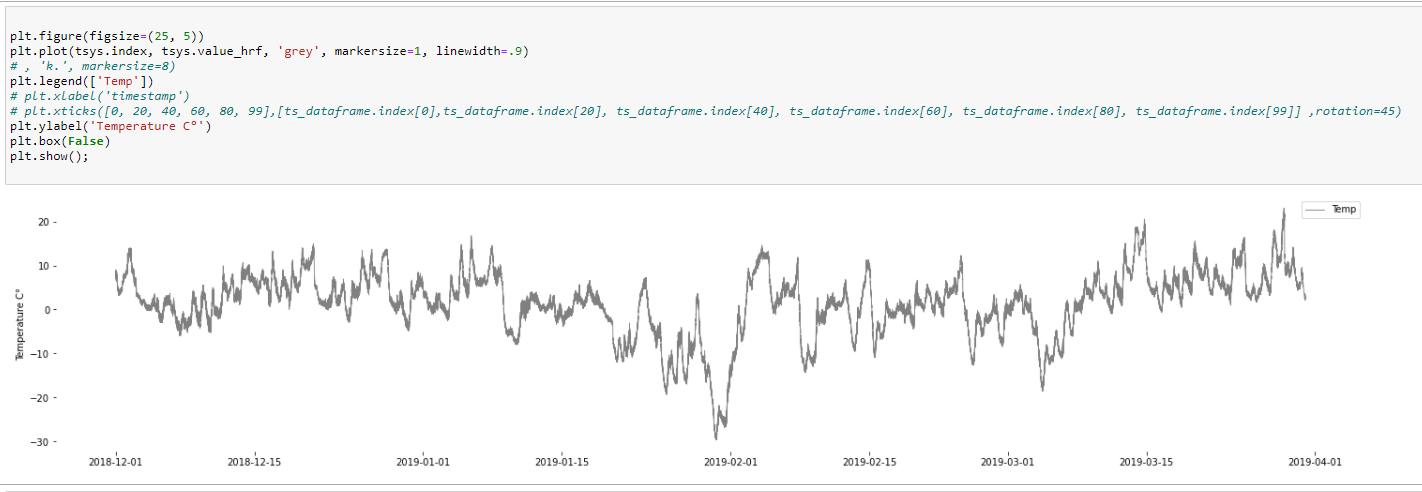

In [88]:
%cd D:\GITHUB_Repos\SensorAnalysis\ENTER\results

D:\GITHUB_Repos\SensorAnalysis\ENTER\results


In [79]:
# PLOT: two month window with detailed title going forward (KEEP)

```Saving some plots```

In [ ]:
%cd D:\GITHUB_Repos\SensorAnalysis\ENTER\results

```Plotting our raw temperature data to see what it looks like```

In [87]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is A060-E317

 Directory of D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION

09/24/2021  11:25 AM    <DIR>          .
09/24/2021  11:25 AM    <DIR>          ..
09/16/2021  02:44 PM       104,840,548 anomaly-detection-using-facebook-s-prophet_WORKING.html
09/16/2021  02:44 PM       116,012,996 anomaly-detection-using-facebook-s-prophet_WORKING.ipynb
09/20/2021  06:57 PM    <DIR>          ATMOSPHERIC_PRESSURE_DATA_AOT
09/22/2021  07:40 PM         1,025,143 db1.png
09/22/2021  07:41 PM           486,613 db2.png
09/16/2021  07:57 PM        17,071,121 facebook_prophet_code_and_html.zip
09/20/2021  11:11 AM         1,313,847 filename5.png
09/22/2021  10:35 PM         1,005,098 finally.png
09/22/2021  10:36 PM         1,004,663 finally2.png
09/22/2021  10:39 PM         1,072,326 finally3.png
09/20/2021  01:46 PM         1,043,602 full_year_temp_2019.png
09/16/2021  07:58 PM    <DIR>          put_back
09/20/2021  10:07 AM            61,287 s

<Figure size 1584x648 with 0 Axes>

Text(0, 0.5, 'Temperature F°')

Text(0.5, 1.0, 'Temperature Data - Chicago Sensor (time window: 1Q 2019,  lat/lon: 41.751295,87.605288,  node location identifier: 001e0610ee36,  subsensor identifier: tsys01)')

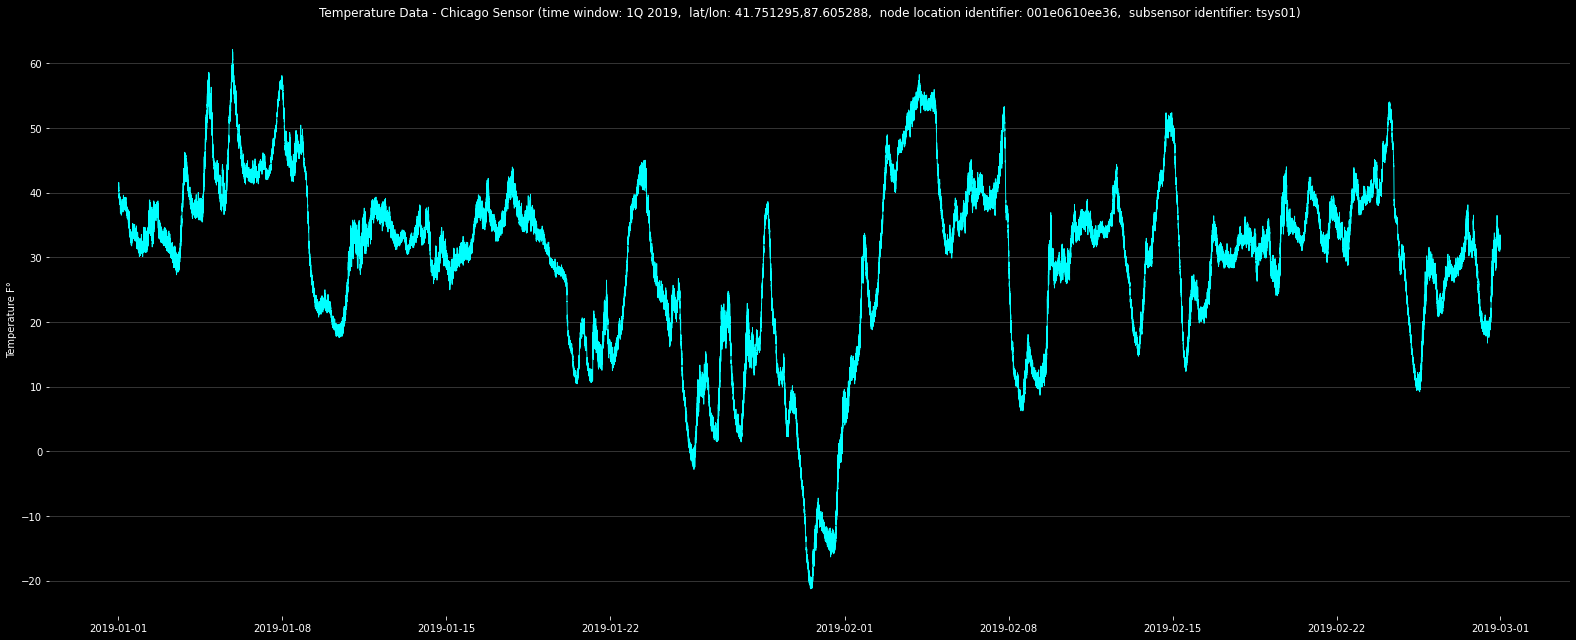

In [86]:
plt.figure(figsize=(22, 9))
plt.plot(tsys.index, tsys.value_hrf, 'cyan', markersize=1, linewidth=.9, label="temp sensor")
# , 'k.', markersize=8)  
#      plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
# 051 Cottage Grove Ave & 79th St Chicago IL
plt.title(r'Temperature Data - Chicago Sensor (time window: 1Q 2019,  lat/lon: 41.751295,87.605288,  node location identifier: 001e0610ee36,  subsensor identifier: tsys01)')
plt.grid(axis='y', color='grey', linestyle='-', linewidth=.5, alpha=.8)
plt.locator_params(axis='y', nbins=10)
# plt.legend(loc = "upper right")
plt.tight_layout()
# plt.show(); 
plt.savefig('single_subsensor_temp_data_plotted_two_months.png', dpi=600)

https://goo.gl/maps/fjpnRfH7j4BkUfbR9

In [ ]:
### DBSCAN user guide:

```
Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)

   DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
   
   Perform DBSCAN clustering from vector array or distance matrix.
   
   DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
   Finds core samples of high density and expands clusters from them.
   Good for data which contains clusters of similar density.
   
   Read more in the :ref:`User Guide <dbscan>`.
   
   Parameters
   ----------
   eps : float, default=0.5
       The maximum distance between two samples for one to be considered
       as in the neighborhood of the other. This is not a maximum bound
       on the distances of points within a cluster. This is the most
       important DBSCAN parameter to choose appropriately for your data set
       and distance function.
   
   min_samples : int, default=5
       The number of samples (or total weight) in a neighborhood for a point
       to be considered as a core point. This includes the point itself.
   
   metric : string, or callable, default='euclidean'
       The metric to use when calculating distance between instances in a
       feature array. If metric is a string or callable, it must be one of
       the options allowed by :func:`sklearn.metrics.pairwise_distances` for
       its metric parameter.
       If metric is "precomputed", X is assumed to be a distance matrix and
       must be square. X may be a :term:`Glossary <sparse graph>`, in which
       case only "nonzero" elements may be considered neighbors for DBSCAN.
   
       .. versionadded:: 0.17
          metric *precomputed* to accept precomputed sparse matrix.
   
   metric_params : dict, default=None
       Additional keyword arguments for the metric function.
   
       .. versionadded:: 0.19
   
   algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
       The algorithm to be used by the NearestNeighbors module
       to compute pointwise distances and find nearest neighbors.
       See NearestNeighbors module documentation for details.
   
   leaf_size : int, default=30
       Leaf size passed to BallTree or cKDTree. This can affect the speed
       of the construction and query, as well as the memory required
       to store the tree. The optimal value depends
       on the nature of the problem.
   
   p : float, default=None
       The power of the Minkowski metric to be used to calculate distance
       between points. If None, then ``p=2`` (equivalent to the Euclidean
       distance).
   
   n_jobs : int, default=None
       The number of parallel jobs to run.
       ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
       ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
       for more details.
   
 
   Attributes
   ----------
   core_sample_indices_ : ndarray of shape (n_core_samples,)
       Indices of core samples.
   
   components_ : ndarray of shape (n_core_samples, n_features)
       Copy of each core sample found by training.
   
   labels_ : ndarray of shape (n_samples)
       Cluster labels for each point in the dataset given to fit().
       Noisy samples are given the label -1.
   
   Examples
   --------
   >>> from sklearn.cluster import DBSCAN
   >>> import numpy as np
   >>> X = np.array([[1, 2], [2, 2], [2, 3],
   ...               [8, 7], [8, 8], [25, 80]])
   >>> clustering = DBSCAN(eps=3, min_samples=2).fit(X)
   >>> clustering.labels_
   array([ 0,  0,  0,  1,  1, -1])
   >>> clustering
   DBSCAN(eps=3, min_samples=2)
   
   See Also
   --------
   OPTICS : A similar clustering at multiple values of eps. Our implementation
       is optimized for memory usage.
   
   Notes
   -----
   For an example, see :ref:`examples/cluster/plot_dbscan.py
   <sphx_glr_auto_examples_cluster_plot_dbscan.py>`.
   
   This implementation bulk-computes all neighborhood queries, which increases
   the memory complexity to O(n.d) where d is the average number of neighbors,
   while original DBSCAN had memory complexity O(n). It may attract a higher
   memory complexity when querying these nearest neighborhoods, depending
   on the ``algorithm``.
   
   One way to avoid the query complexity is to pre-compute sparse
   neighborhoods in chunks using
   :func:`NearestNeighbors.radius_neighbors_graph
   <sklearn.neighbors.NearestNeighbors.radius_neighbors_graph>` with
   ``mode='distance'``, then using ``metric='precomputed'`` here.
   
   Another way to reduce memory and computation time is to remove
   (near-)duplicate points and use ``sample_weight`` instead.
   
   :class:`cluster.OPTICS` provides a similar clustering with lower memory
   usage.
   
   References
   ----------
   Ester, M., H. P. Kriegel, J. Sander, and X. Xu, "A Density-Based
   Algorithm for Discovering Clusters in Large Spatial Databases with Noise".
   In: Proceedings of the 2nd International Conference on Knowledge Discovery
   and Data Mining, Portland, OR, AAAI Press, pp. 226-231. 1996
   
   Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017).
   DBSCAN revisited, revisited: why and how you should (still) use DBSCAN.
   ACM Transactions on Database Systems (TODS), 42(3), 19.
   
   Method resolution order:
       DBSCAN
       sklearn.base.ClusterMixin
       sklearn.base.BaseEstimator
       builtins.object
   
   Methods defined here:
   
   __init__(self, eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
       Initialize self.  See help(type(self)) for accurate signature.
   
   fit(self, X, y=None, sample_weight=None)
       Perform DBSCAN clustering from features, or distance matrix.
       
       Parameters
       ----------
       X : {array-like, sparse matrix} of shape (n_samples, n_features), or             (n_samples, n_samples)
           Training instances to cluster, or distances between instances if
           ``metric='precomputed'``. If a sparse matrix is provided, it will
           be converted into a sparse ``csr_matrix``.
       
       sample_weight : array-like of shape (n_samples,), default=None
           Weight of each sample, such that a sample with a weight of at least
           ``min_samples`` is by itself a core sample; a sample with a
           negative weight may inhibit its eps-neighbor from being core.
           Note that weights are absolute, and default to 1.
       
       y : Ignored
           Not used, present here for API consistency by convention.
       
       Returns
       -------
       self
   
   fit_predict(self, X, y=None, sample_weight=None)
       Perform DBSCAN clustering from features or distance matrix,
       and return cluster labels.
       
       Parameters
       ----------
       X : {array-like, sparse matrix} of shape (n_samples, n_features), or             (n_samples, n_samples)
           Training instances to cluster, or distances between instances if
           ``metric='precomputed'``. If a sparse matrix is provided, it will
           be converted into a sparse ``csr_matrix``.
       
       sample_weight : array-like of shape (n_samples,), default=None
           Weight of each sample, such that a sample with a weight of at least
           ``min_samples`` is by itself a core sample; a sample with a
           negative weight may inhibit its eps-neighbor from being core.
           Note that weights are absolute, and default to 1.
       
       y : Ignored
           Not used, present here for API consistency by convention.
       
       Returns
       -------
       labels : ndarray of shape (n_samples,)
           Cluster labels. Noisy samples are given the label -1.
   
   ----------------------------------------------------------------------
   Data descriptors inherited from sklearn.base.ClusterMixin:
   
   __dict__
       dictionary for instance variables (if defined)
   
   __weakref__
       list of weak references to the object (if defined)
   
   ----------------------------------------------------------------------
   Methods inherited from sklearn.base.BaseEstimator:
   
   __getstate__(self)
   
   __repr__(self, N_CHAR_MAX=700)
       Return repr(self).
   
   __setstate__(self, state)
   
   
   get_params(self, deep=True)
       Get parameters for this estimator.
       
       Parameters
       ----------
       deep : bool, default=True
           If True, will return the parameters for this estimator and
           contained subobjects that are estimators.
       
       Returns
       -------
       params : dict
           Parameter names mapped to their values.
   

```

In [ ]:
STOP:

In [ ]:
# this time, i WONT use the standard scaler, just to see what we see...

#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

from sklearn.cluster import DBSCAN

#   eps=0.2, min_samples=8

#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

# X = StandardScaler().fit_transform(X)
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))  # i think smarter to do to_frame() instead... 
                  

In [ ]:
db.get_params(deep=True)

In [ ]:

label=db.labels_

from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

# Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)

print('\nNo of clusters:',n_clusters, '\n\n')

# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')

tsys["cluster"] = db.labels_

print(tsys["cluster"].value_counts(), '\n')

#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


``` 
RESULTS:
========    

db = DBSCAN(eps=0.03, min_samples=6, metric='euclidean', n_jobs=-1)
 0    139811
 3      4950
 2        37
 1        26
-1        19
 4        10


db = DBSCAN(eps=0.04, min_samples=5, metric='euclidean', n_jobs=-1)
 0    144840
-1        13


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
 0    198364
 4      4990
 1        66
-1        41
 2        10
 3        10
 



`````

In [ ]:

# much smaller time range now !!!!!!!

plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# , 'k.', markersize=8)  
plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
plt.show();


In [ ]:
tsys.head(10)

In [ ]:

#  0    139839
#  1      4987
# -1        18
#  2         9
    
# No of clusters: 3 
#  0    139839
#  1      4987
# -1        18
#  2         9
       
# --- latest --- 
#  0    198364
#  4      4990
#  1        66
# -1        41
#  2        10
#  3        10
# Name: cluster, dtype: int64 
      
plt.style.use('dark_background')

plt.figure(figsize=(25, 7))

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

plt.plot(tsys.index, tsys.value_hrf, 'white', markersize=1, linewidth=.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']


e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();        


### Thus

1. Lowering the eps value causes less and less anomalies to be determined 
1. Increasing the eps value then...

---

<br><br><br><br><br><br><br>

---


# Repeating:

In [ ]:

#   eps=0.2, min_samples=8
#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.08, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))
label=db.labels_
from sklearn import metrics
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
n_clusters=len(set(label))- (1 if -1 in label else 0)
print('\nNo of clusters:',n_clusters, '\n\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


In [ ]:
     
plt.style.use('seaborn-poster')

plt.figure(figsize=(25, 8))
a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.plot(tsys.index, tsys.value_hrf, 'black', markersize=1, linewidth=.9)
c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']
e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']

plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)
# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)
# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)
# plt.show();   

plt.savefig('db2.png', dpi=600); 


<br>

<br>

<br>

<br>

<br>

In [ ]:
START: 

### _We will StandardScaler our data now_

In [ ]:
tsys.columns

In [ ]:
# PYTHONIC:
thisFilter = tsys.filter('cluster')
tsys.drop(thisFilter, inplace=True, axis=1)
# tsys.drop('cluster', axis=1, inplace=True)  # if you iterate, you need to remove ! 

In [ ]:
tsys.columns

In [ ]:
X = tsys['value_hrf'].copy()

In [ ]:
X[:10]

In [ ]:
X.values[:10]

In [ ]:
# Utilize standard scaler 
X = StandardScaler().fit_transform(X.values.reshape(-1,1))

In [ ]:
X[:10]  # normalized ! ! ! ! 

In [ ]:
# len(X)  # 203 481

In [ ]:
plt.style.use('default')
plt.figure(figsize=(25, 7))
plt.plot(tsys.index, X, 'grey', markersize=1, linewidth=.9)
# plt.legend()
plt.box(False)
print("Standard Scaler View:")
plt.show();
# normalized 

### ITERATE 0:

In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************
# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Temp Data Anomalies   1Q-2019   [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))

# plt.legend()
plt.legend(loc='upper center', borderaxespad=0.)

plt.tight_layout()
plt.box(False)
# plt.show();
plt.savefig('dbrun_1.png', dpi=800); 

In [ ]:
# 

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION (-1):')
# for date in a.values:
#     print(a)
for c in range(140):
    print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=0.)
plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 20:07:20'), pd.Timestamp('2019-01-31 16:26:33'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))


plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# plotting smaller easier to see regions

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION (-1):')
# for date in a.values:
#     print(a)
for c in range(140):
    print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.2, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=1)
# plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 19:45:00'), pd.Timestamp('2019-01-05 22:00:00'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION (-1):')
# for date in a.values:
#     print(a)
for c in range(140):
    print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=0.)
plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 20:07:20'), pd.Timestamp('2019-01-31 16:26:33'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))


plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# CRITICAL, DO NOT LOSE THIS CODE ! 

In [ ]:
# use dark background !!!!!!!!!!!!!!!!!!!!!!
plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(figsize=(30,8))
# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# plt.style.use('white_background')
plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

# --- original code 
# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

# e = tsys.loc[tsys['cluster'] == 2].index
# f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

# g = tsys.loc[tsys['cluster'] == 3].index
# h= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)


a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(130,20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(-140, 20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc='upper center', borderaxespad=0.)
plt.ylabel('Temperature F°')
plt.box(False)
plt.tight_layout()
plt.show(); 

# plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)

In [ ]:
# clusters seem to form near the yellow... but hard to see...

### ITERATE 1:

In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************
# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 8))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Temp Data Anomalies, eps = {}'.format(myeps))

plt.legend()
plt.tight_layout()
plt.box(False)
plt.show();

In [ ]:

# use dark background !!!!!!!!!!!!!!!!!!!!!!

fig, ax = plt.subplots(figsize=(30,8))

# plt.style.use('white_background')
# plt.figure(figsize=(30, 8))

plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

g = tsys.loc[tsys['cluster'] == 3].index
h= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(130,20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(-140, 20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc = "upper left")

plt.ylabel('Temperature F°')
plt.box(False)

plt.tight_layout()
# plt.show(); 

plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)


https://en.wikipedia.org/wiki/January%E2%80%93February_2019_North_American_cold_wave

> https://weatherspark.com/m/14091/2/Average-Weather-in-February-in-Chicago-Illinois-United-States

Five records were set for Chicago for the month of January 2019:
* Record daily snowfall of 5.0 inches on the 28th.
* Record daily minimum temperature of -23 degrees on the 30th.
* Record daily lowest maximum temperature of -10 degrees on the
  30th.
* Record daily minimum temperature of -21 degrees on the 31st.
* Tied daily lowest maximum temperature of 1 degree on the 31st.

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(g, h, color='grey', label = 'Anomaly Cluster 3', s=5, alpha=0.5)
plt.show();  

In [ ]:

# db = DBSCAN(eps=0.01, min_samples=25, metric='euclidean', n_jobs=-1).fit(X)

plt.figure(figsize=(35, 50))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']

e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']

g = tsys.loc[tsys['cluster'] == 3].index
h= tsys[(tsys['cluster'] == 3)]['value_hrf']

plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=50, alpha=0.6)

plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

plt.scatter(g, h, color='black', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();  


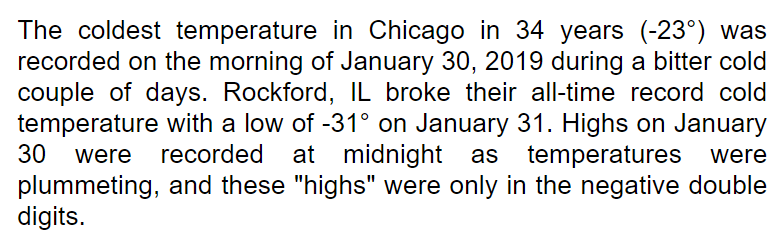

In [ ]:

# The lowest temperature at Chicago was -23 degrees observed at Chicago O'Hare International Airport on January 30th.
# The lowest temperature at Rockford was -31 degrees observed at Chicago Rockford International Airport on January 31st. 
# The lowest temperature at NWS Chicago in Romeoville was -24 degrees.  This ties the record set on January 16, 2009.
# The lowest temperature at Chicago Midway Airport 3SW observed was -22 degrees on January 31, 2019. 


In [ ]:

plt.figure(figsize=(20, 6))
plt.scatter(g, h, color='blue', label = 'Anomaly Cluster 3', s=5, alpha=0.5)
plt.show();  

# region cluster of anomalous temperature ! ! ! 


In [ ]:

plt.figure(figsize=(20, 20))
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=50, alpha=0.6)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)
plt.show();  


In [ ]:

plt.figure(figsize=(20, 20))
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=50, alpha=0.6)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)
plt.show();  


#### plotting:

In [ ]:

plt.figure(figsize=(25, 5))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']

# e = tsys.loc[tsys['cluster'] == 2].index
# f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();  


```
RESULTS:
    
db = DBSCAN(eps=0.01, min_samples=30, metric='euclidean', n_jobs=-1).fit(X)
 0    139272
 3      4284
 4       664
 2       403
-1       126
 1       104
    

BELOW SHOWN IN PLOT:

db = DBSCAN(eps=0.01, min_samples=20, metric='euclidean', n_jobs=-1).fit(X)
 0    139842
 1      4988
-1        23
NOT BAD ! 


```    

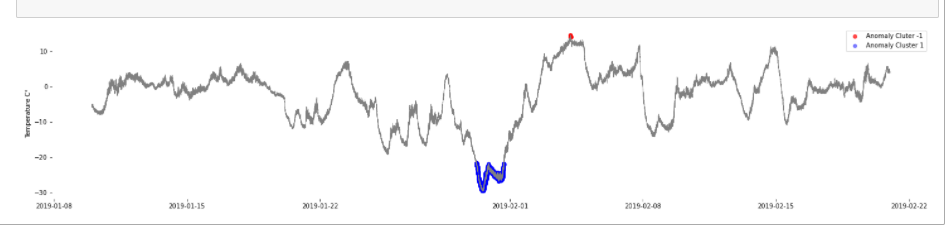

In [ ]:

# ORIGINAL CODE BEFORE I USED THE NEW ABOVE 

# label=db.labels_

# from sklearn import metrics

# #identifying the points which makes up our core points
# sample_cores=np.zeros_like(label,dtype=bool)

# sample_cores[db.core_sample_indices_]=True

# # Calculating the number of clusters

# n_clusters=len(set(label))- (1 if -1 in label else 0)

# print('No of clusters:',n_clusters)


* https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

#### Calculating Metrics:

In [ ]:

# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

# core_samples_mask[db.core_sample_indices_] = True

# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)

# # print('Estimated number of noise points: %d' % n_noise_)

# # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))

# # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))

# # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))

# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))


In [ ]:
# EVERYTHING BELOW THIS LINE STILL WORKING ON:

### Using Tuning Approach:

In [ ]:

from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11)

neighbors = nearest_neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))

plt.plot(distances)

plt.xlabel("Points")

plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)



<br><br>

<br><br>

# Appendix:  Do Not Delete

```python
from sklearn.cluster import DBSCAN
clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))

labels = clustering1.labels_

outlier_pos = np.where(labels == -1)[0]

x = []; y = [];
for pos in outlier_pos:
    x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
    y.append(ts_dataframe['Normalized Profit'].index[pos])
    
plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
plt.plot(y,x,'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.xlabel('Time Period')
plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Normalized Profit')
```

In [ ]:
# # Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()

In [ ]:

# tdf = tdf[tdf['sensor'].isin(['bmp180', 'htu21d', 'pr103j2', 'tsys01'])]


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()


* dont use:
 * tmp421
 * tmp112
 * hih6130
 

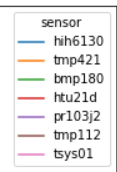

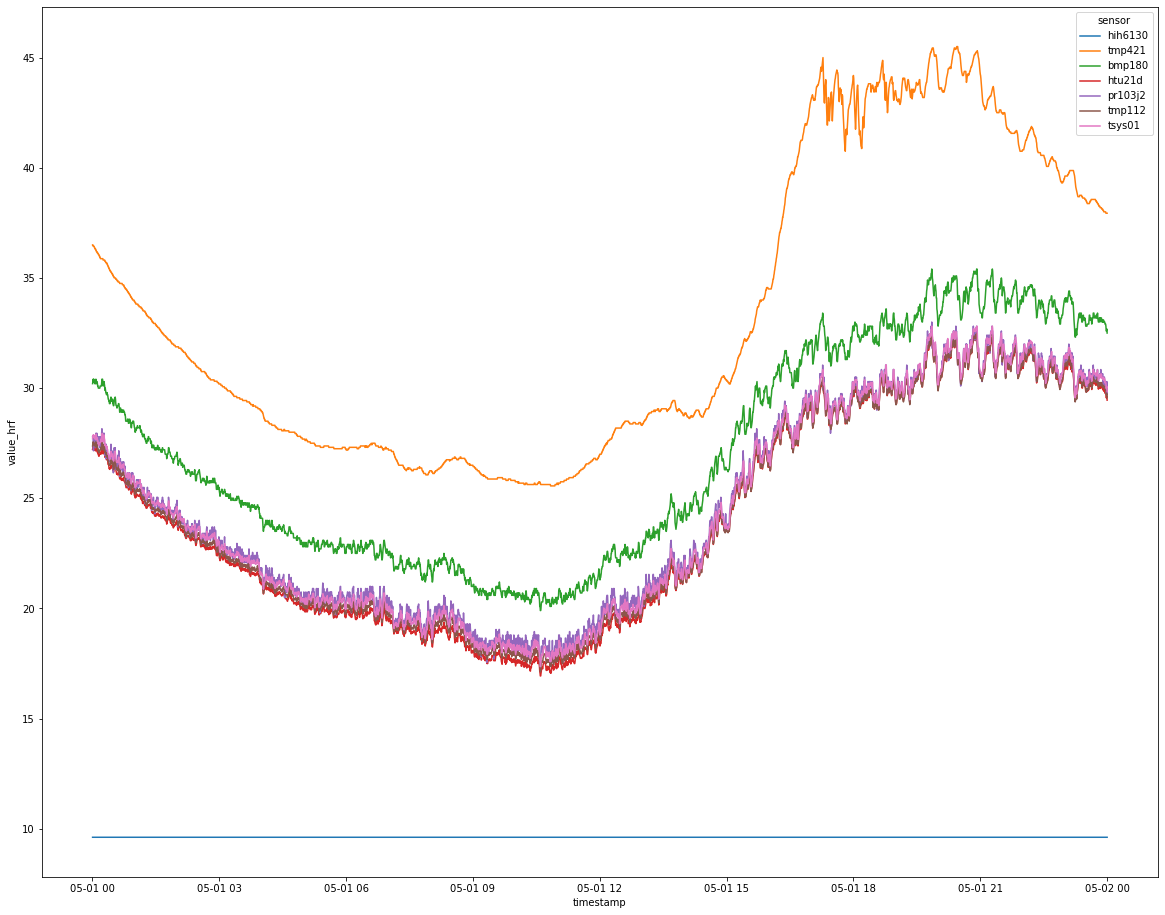

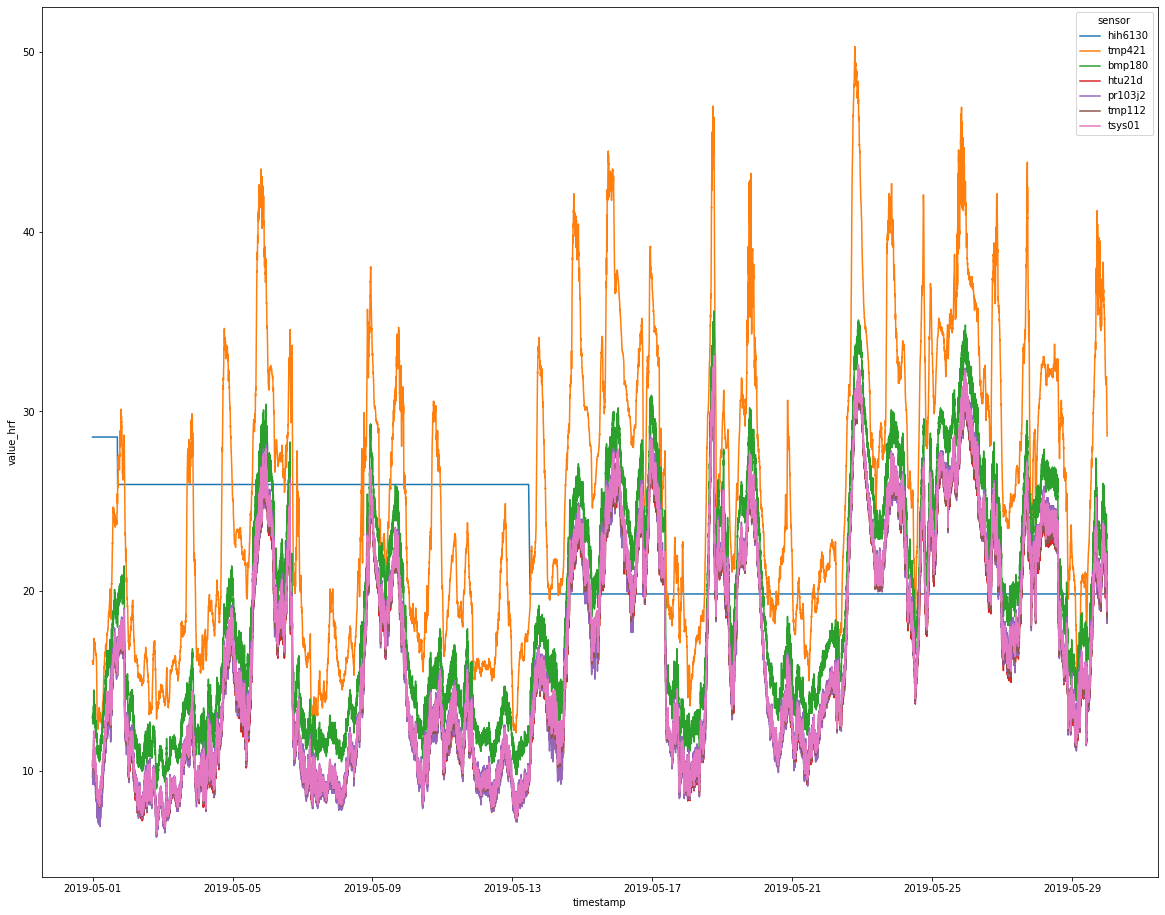

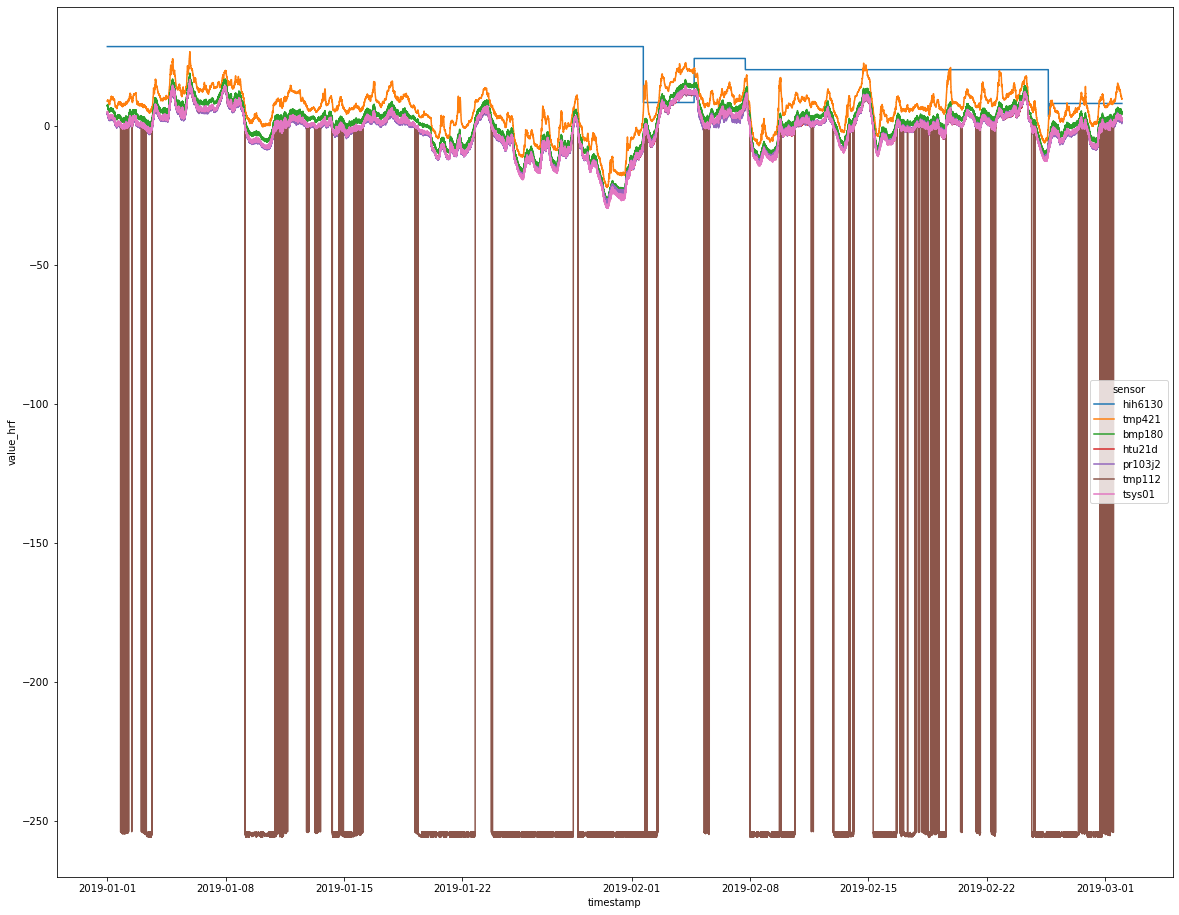

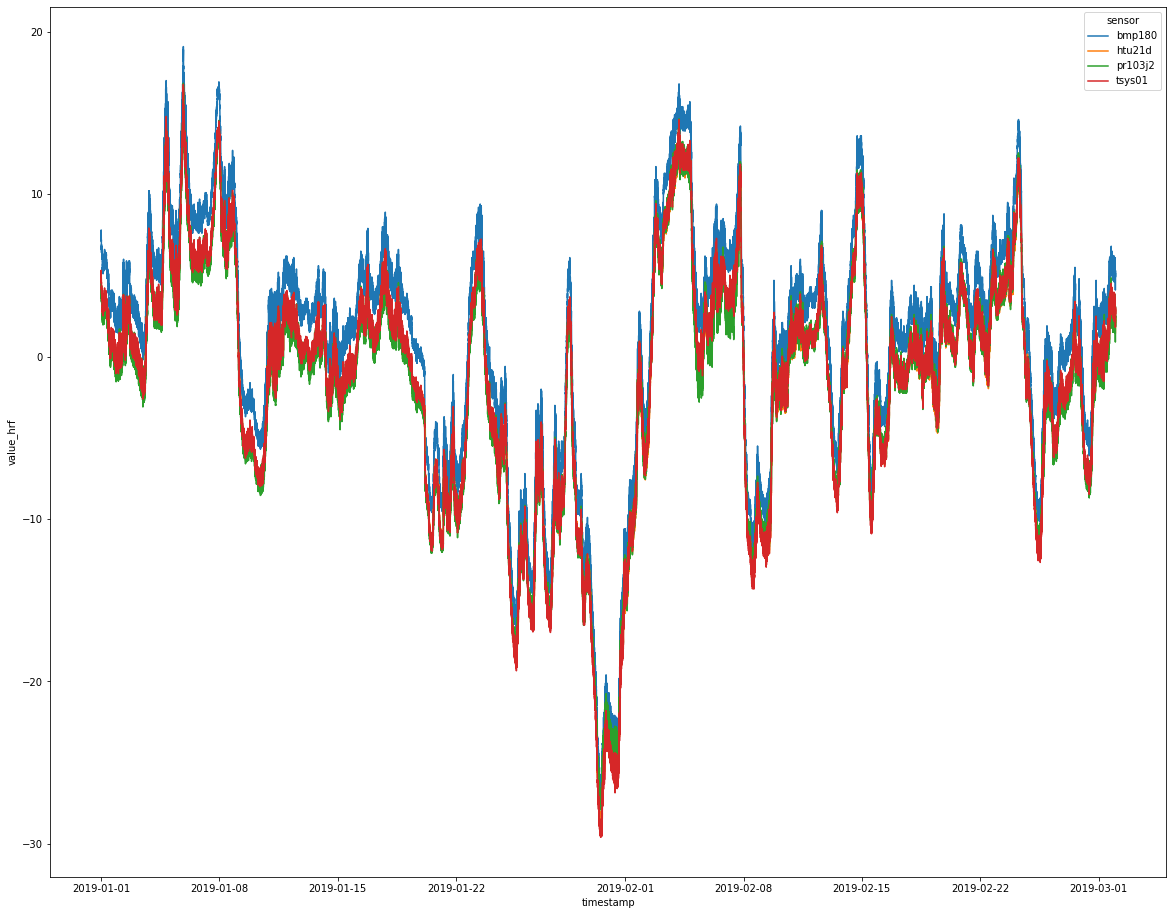

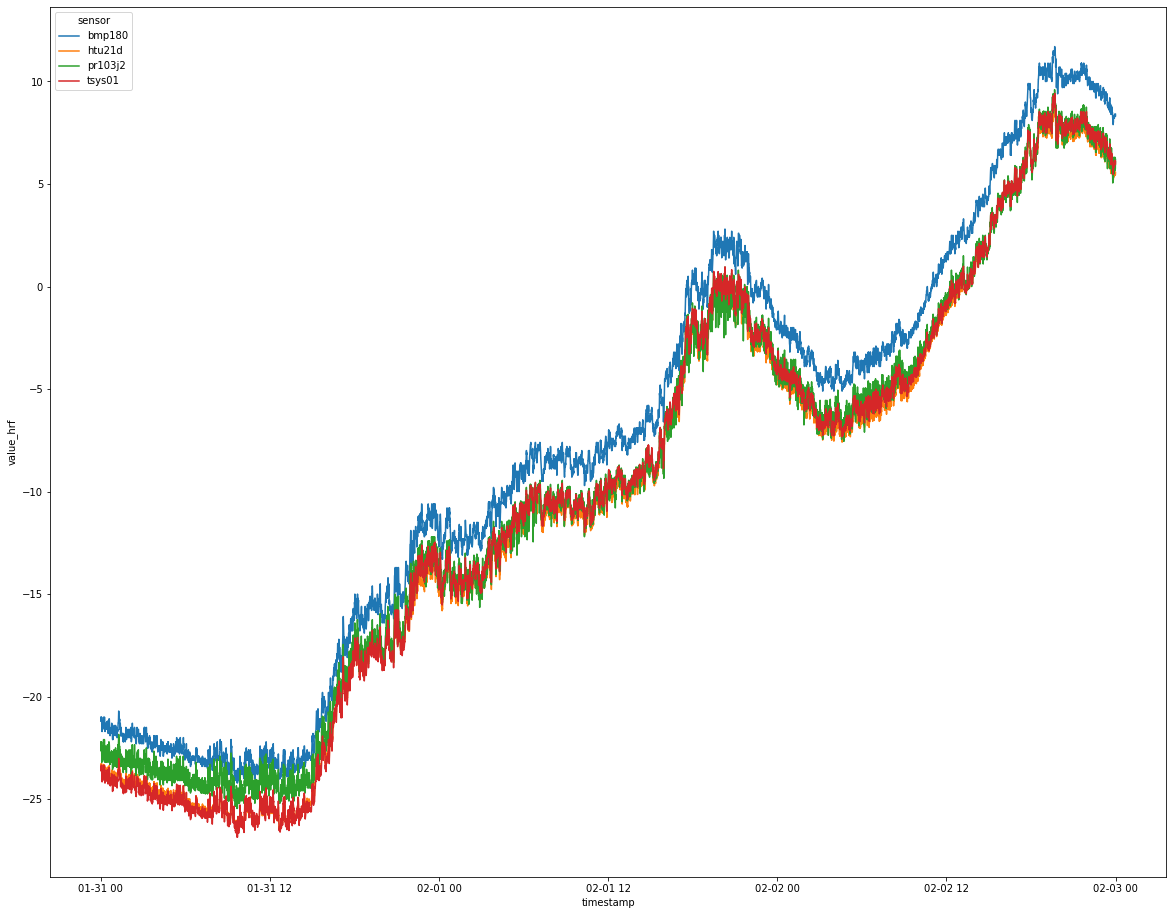

# Examining other sensors:

In [ ]:
minidf.head(10)

In [ ]:
len(minidf)

In [ ]:
len(tdf)

In [ ]:
non_tdf = minidf[minidf.parameter != 'temperature'].copy()

In [ ]:
len(non_tdf)

In [ ]:
for p in non_tdf.parameter.unique(): print(p)

In [ ]:

# non_tdf.head(1000)


In [ ]:

# i dont think we necessariry care too much about acceleration data (although its good to have), but 
# maybe lets focus on 


In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.head(10)

# three sep datavalues ! 


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
hdf.dtypes

In [ ]:

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


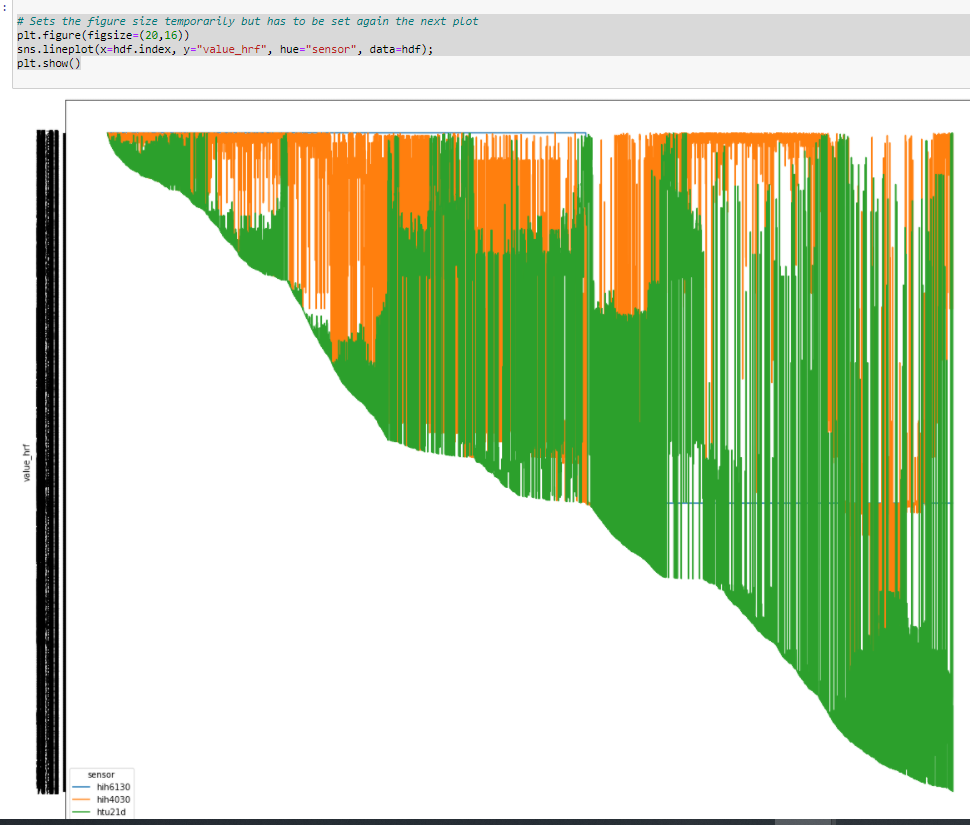

In [ ]:

hdf.value_hrf = hdf.value_hrf.astype(np.float16)
hdf = hdf.loc['2019-02-01 03:00':'2019-02-01 04:00'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()



In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030', 'htu21d'])]

hdf = hdf.loc['2019-02-01':'2019-02-12'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['htu21d'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
# make large numbers more readable by adding commas
# pd.options.display.float_format = '{:,}'.format
# Example
# 123456789.12345 -> 123,456,789.12345



In [ ]:
# from sklearn.cluster import DBSCAN
# clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))
# labels = clustering1.labels_
# outlier_pos = np.where(labels == -1)[0]
# x = []; y = [];
# for pos in outlier_pos:
#     x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
#     y.append(ts_dataframe['Normalized Profit'].index[pos])
    
# plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
# plt.plot(y,x,'r*', markersize=8)  
# plt.legend(['Actual', 'Anomaly Detected'])
# plt.xlabel('Time Period')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
# plt.ylabel('Normalized Profit')